**Анализ температурных данных и мониторинг текущей температуры через OpenWeatherMap API**

In [21]:
! pip install "modin[ray]" -q

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import modin.pandas as mpd
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns
from getpass import getpass
import aiohttp
import asyncio

In [6]:
# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)

In [7]:
data = pd.read_csv("./temperature_data.csv")

In [8]:
data.head()

city   timestamp  temperature  season
0  New York  2010-01-01    -1.738241  winter
1  New York  2010-01-02    -2.650598  winter
2  New York  2010-01-03     6.254581  winter
3  New York  2010-01-04    -1.198835  winter
4  New York  2010-01-05    -2.031502  winter

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [10]:
data['timestamp'] = pd.to_datetime(data['timestamp']) # timestamp типа object, приводим его к datetime

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   city         54750 non-null  object        
 1   timestamp    54750 non-null  datetime64[ns]
 2   temperature  54750 non-null  float64       
 3   season       54750 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.7+ MB


Вычисление дополнительных данных

In [12]:
def modify(data):
    # Добавление статистических данных в DataFrame(скользящего среднего и стандартного отклонения для сглаживания температурных колебаний)
    # Определение аномалий на основе отклонений температуры от скользящее среднее±2σ
    data['mean_temp'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())
    data['std_temp'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())

    data['lower_limit'] = data['mean_temp'] - 2 * data['std_temp']
    data['upper_limit'] = data['mean_temp'] + 2 * data['std_temp']
    data['is_anomaly'] = (data['temperature'] < data['lower_limit']) | (data['temperature'] > data['upper_limit'])
    return data

#### Проверка работы без распараллеливания

In [57]:
default_processed_data = data.copy()
start_time = time.time()
modify(default_processed_data)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.06049656867980957


#### Проверка с распараллеливанием

1) С использованием библиотеки modin

In [59]:
modin_processed_data = mpd.DataFrame(data)
start_time = time.time()
modify(modin_processed_data)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.32856035232543945


2) С использованием multiprocessing

In [60]:
grouped_data = data.groupby(['city', 'season'])
chunks = [pd.DataFrame(group[1]) for group in grouped_data]
start_time = time.time()
with ProcessPoolExecutor() as executor:
    results = executor.map(modify, chunks)
pd.concat(results)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.45603299140930176


**Вывод:** Обычные операции с DataFrame без распараллеливания работают быстрее

### Графики с отображением температуры по городам

На графиках отображены температура, скользящее среднее с окном в 30 дней и аномалии.  
Аномалии отображены красными точками на графиках

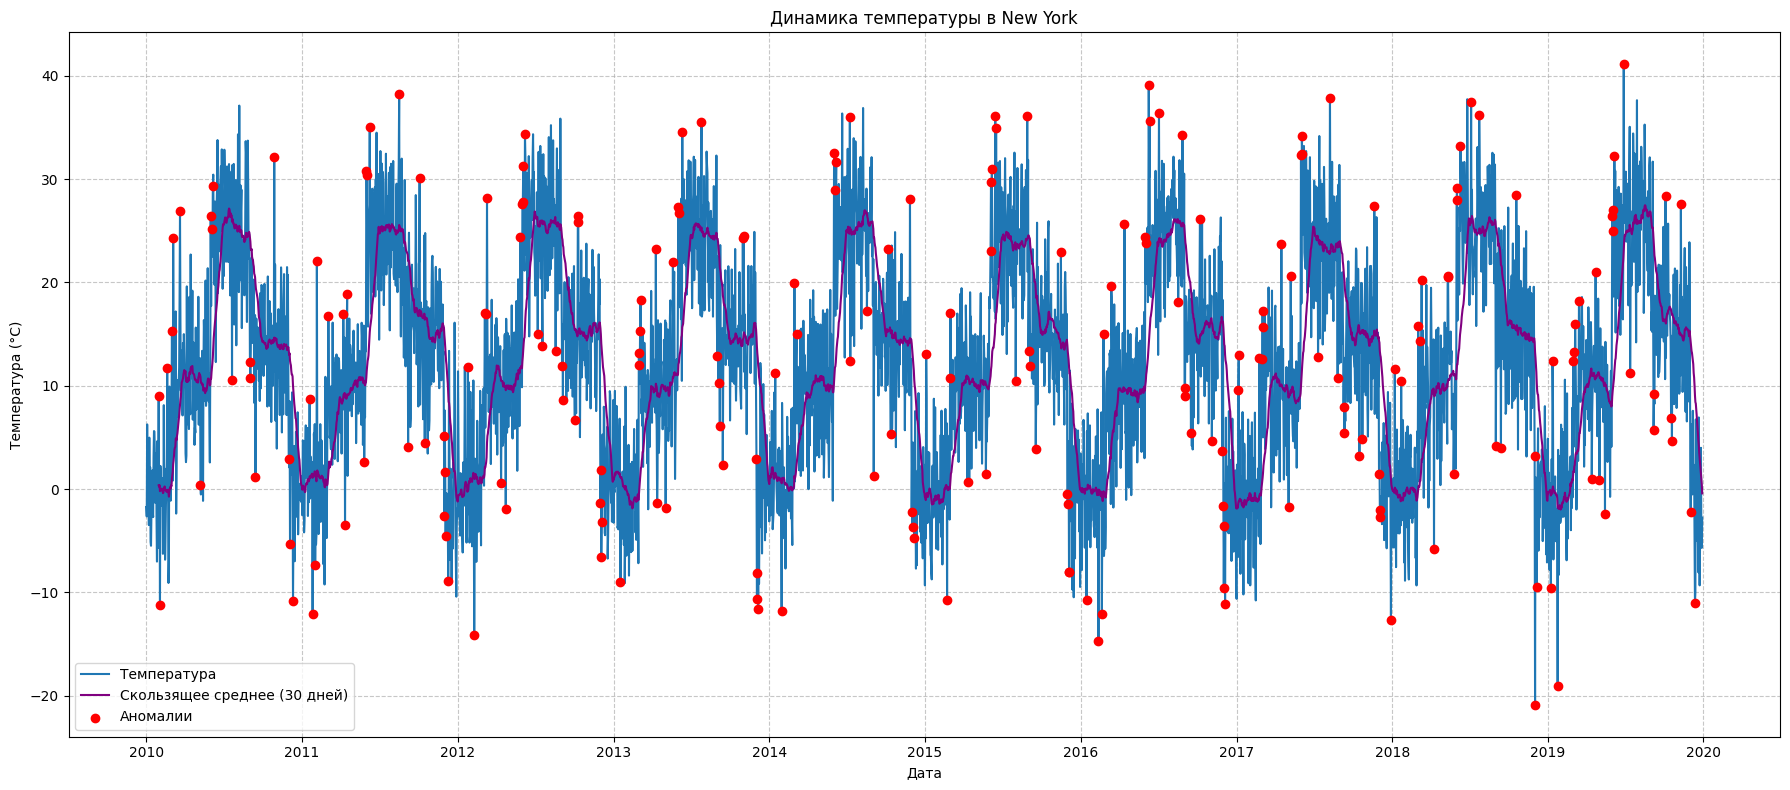

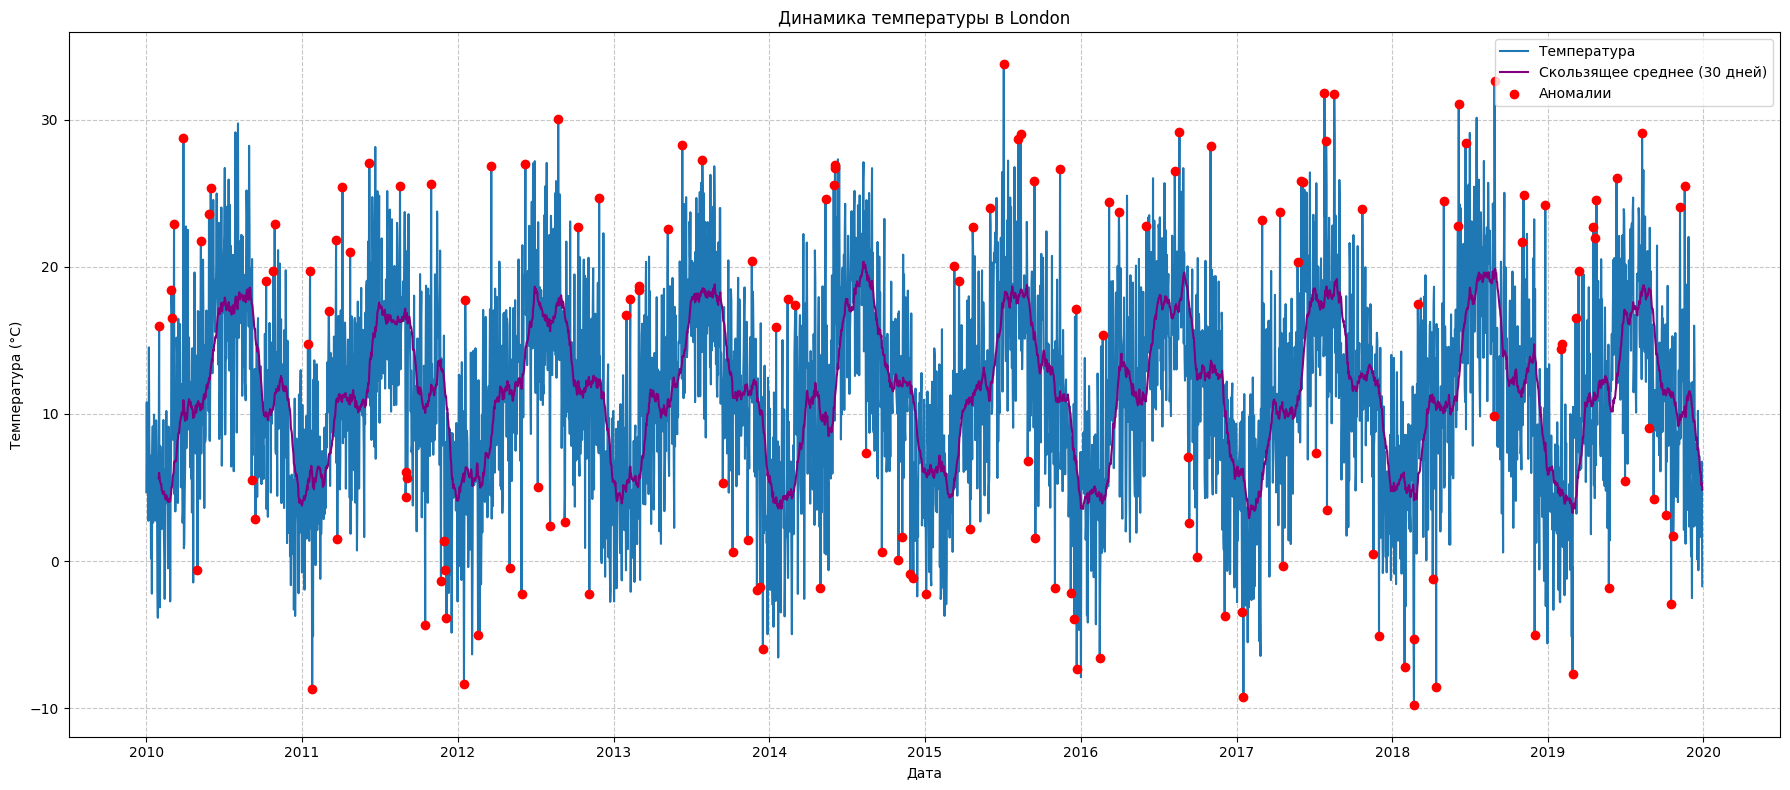

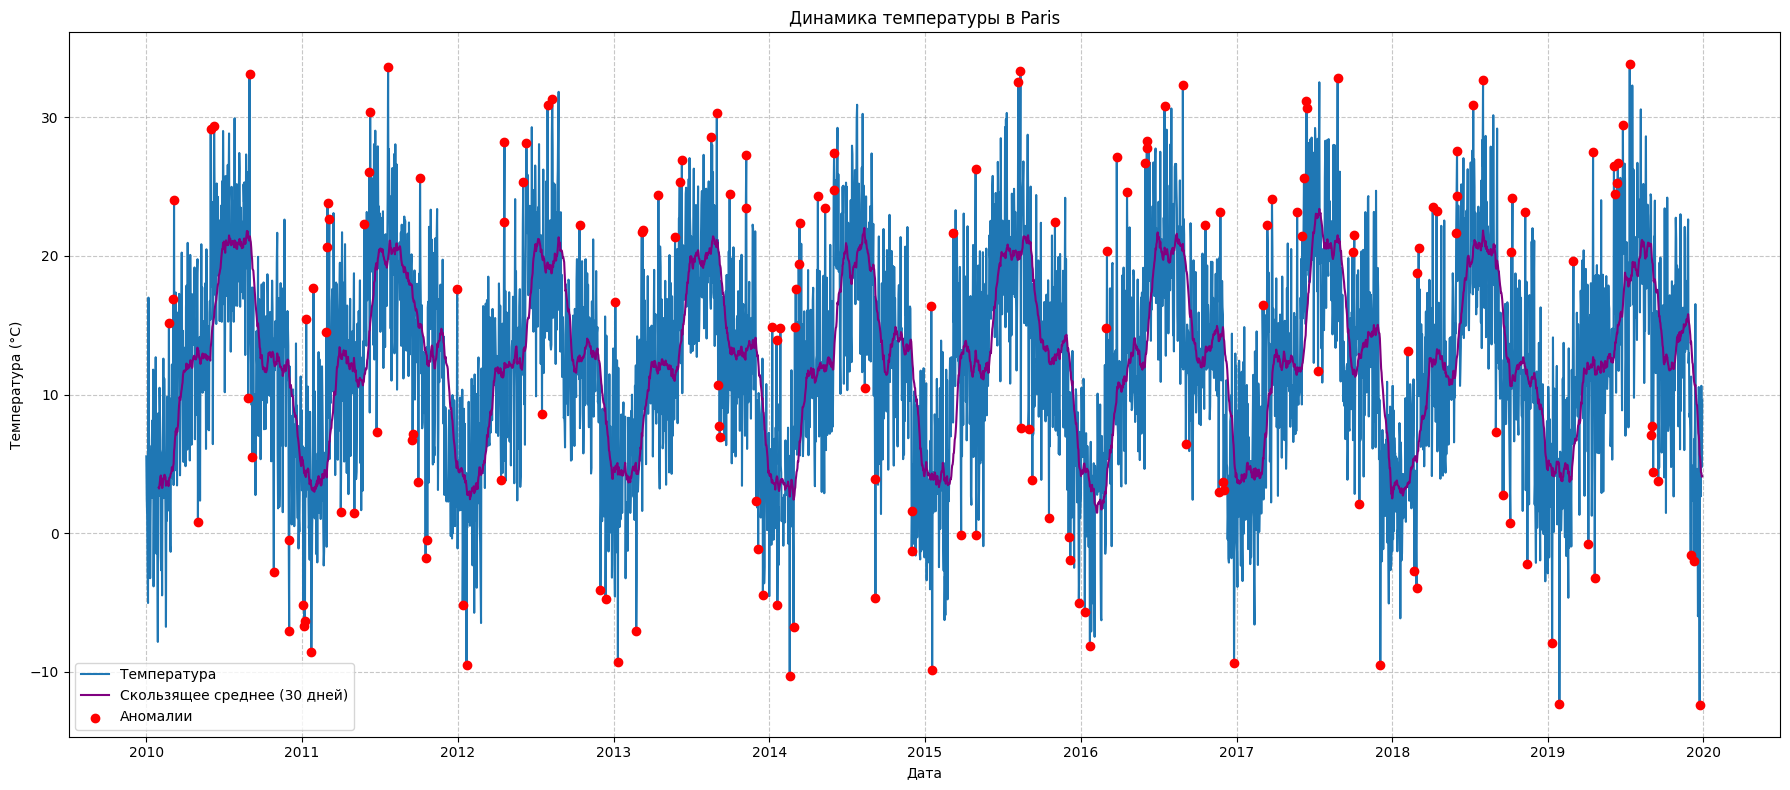

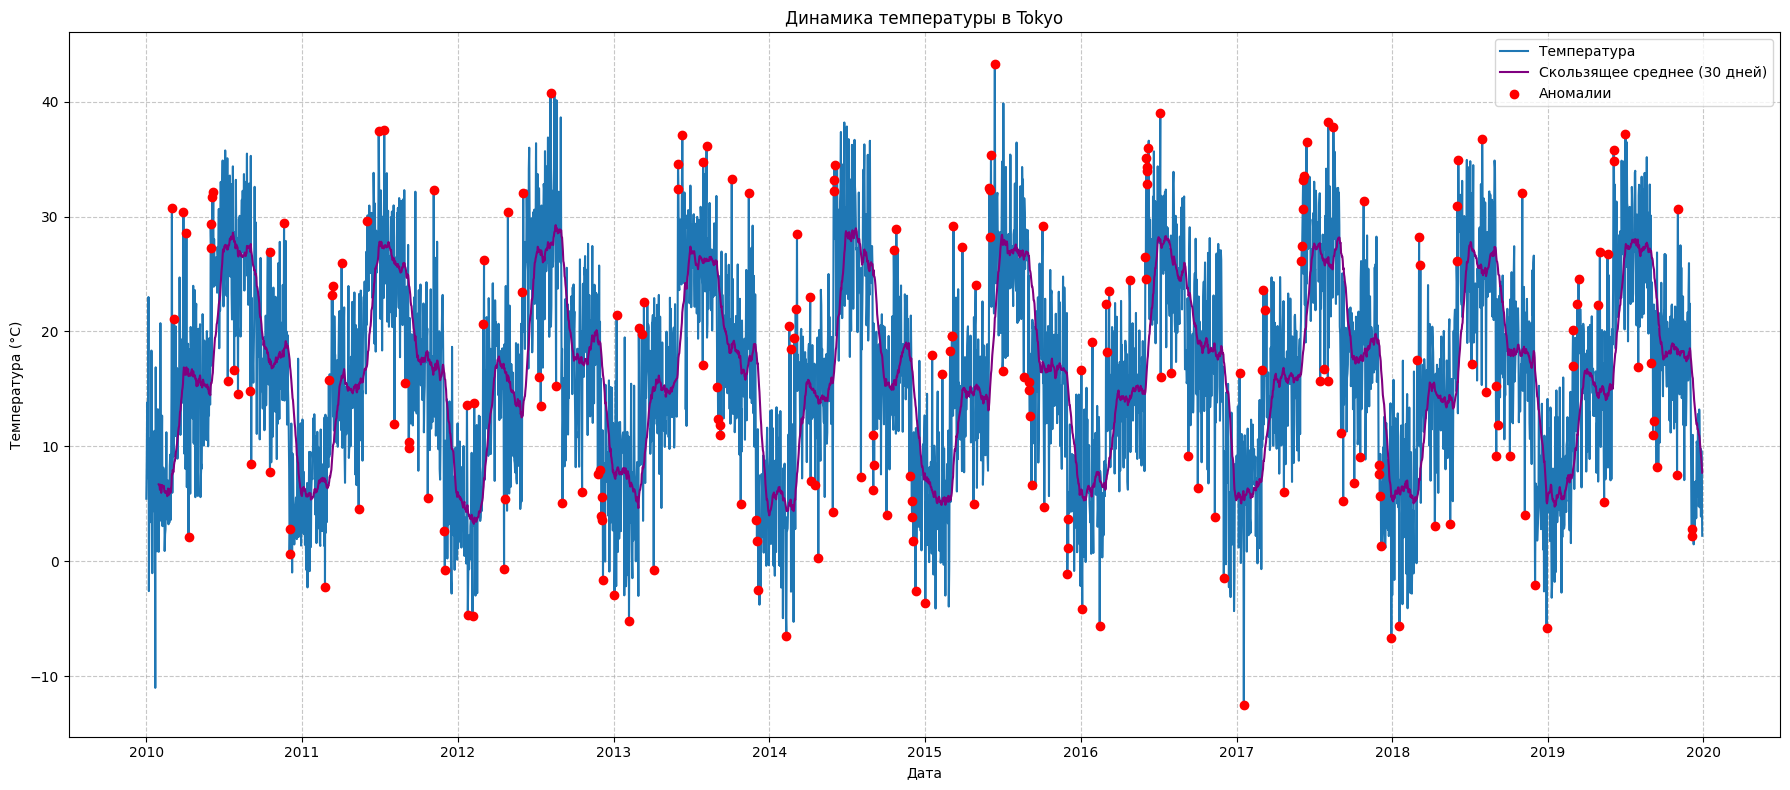

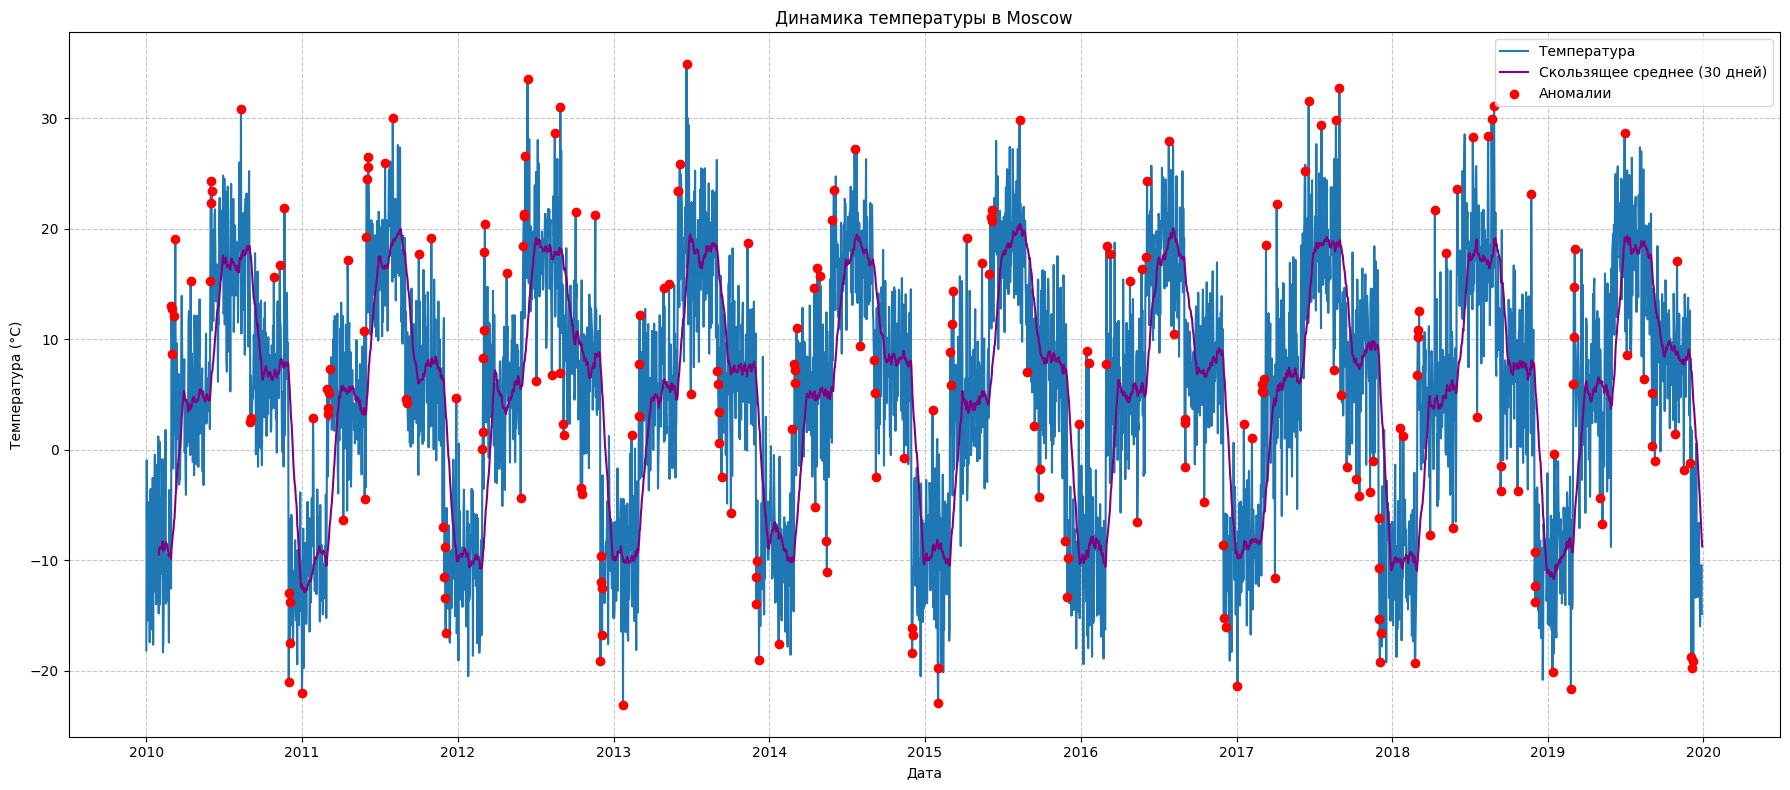

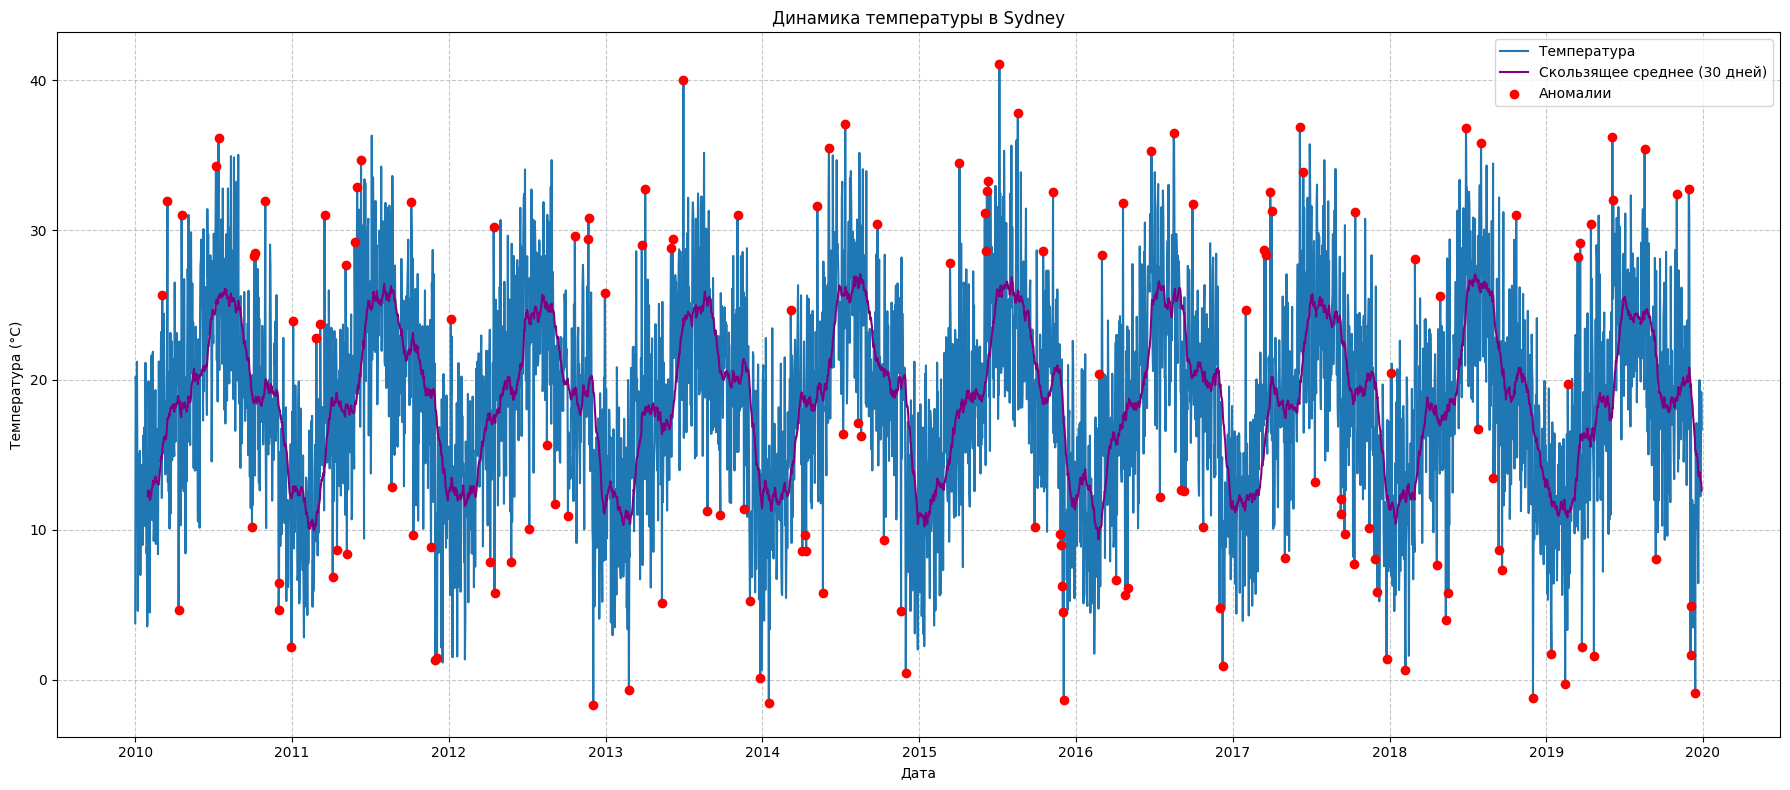

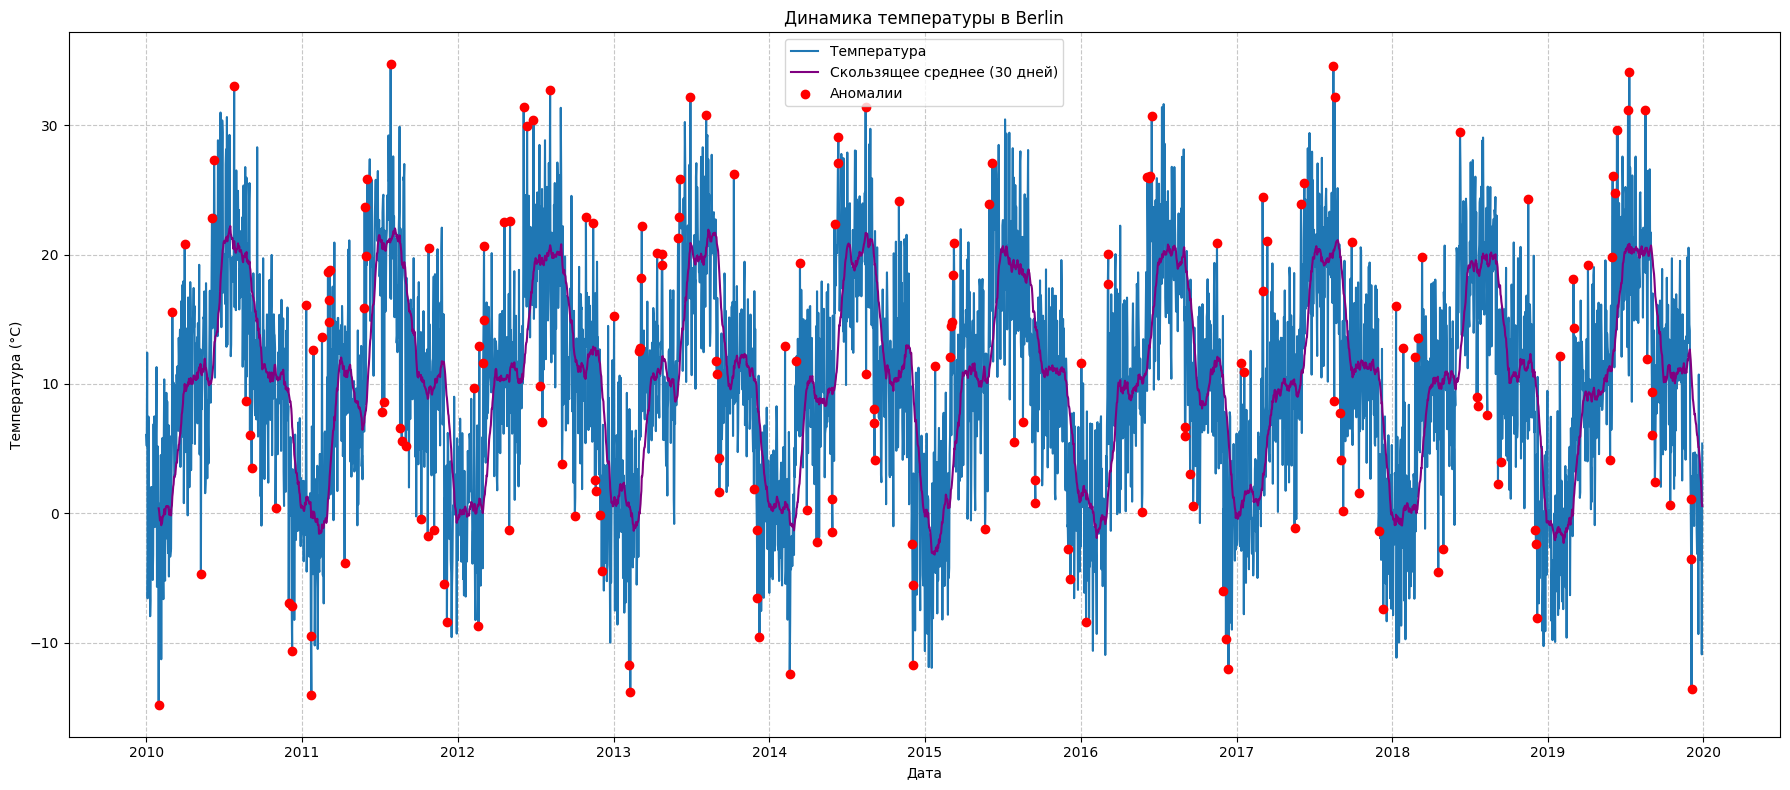

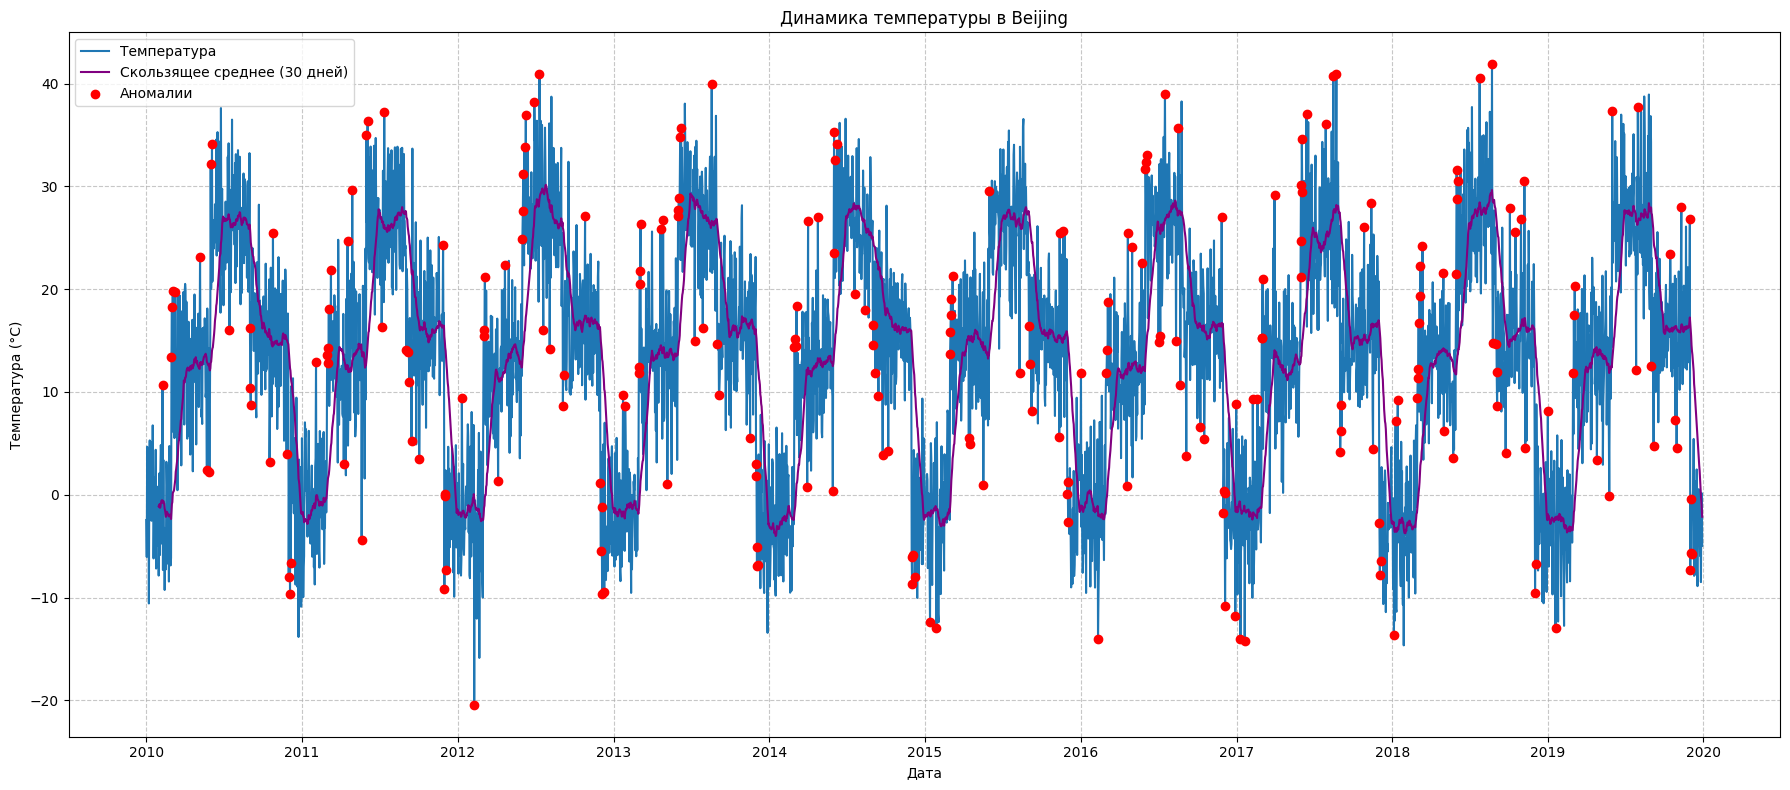

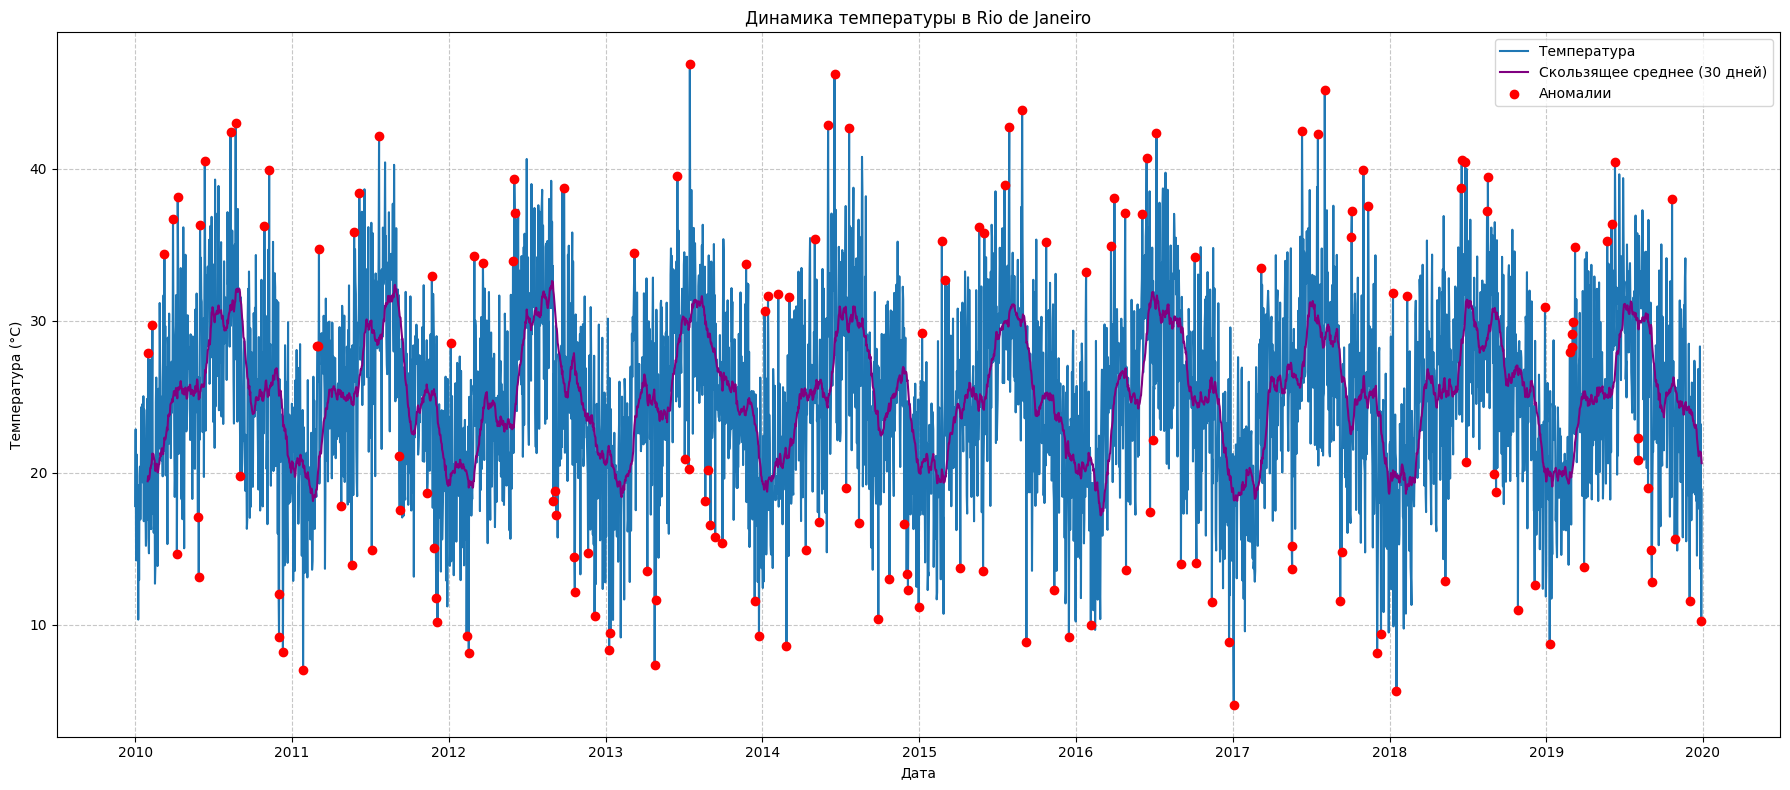

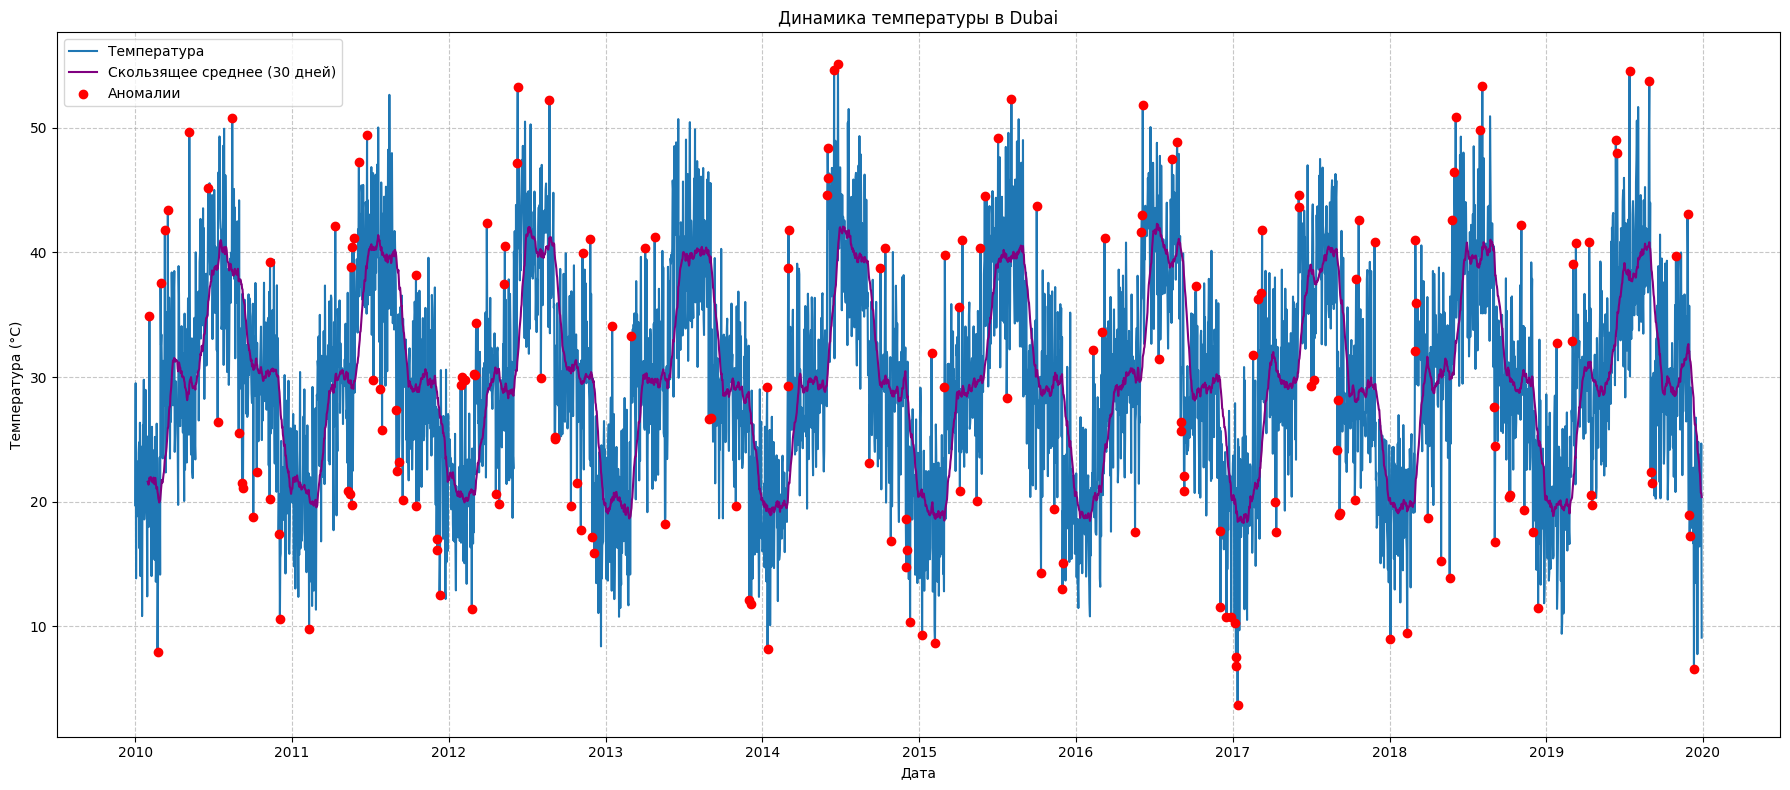

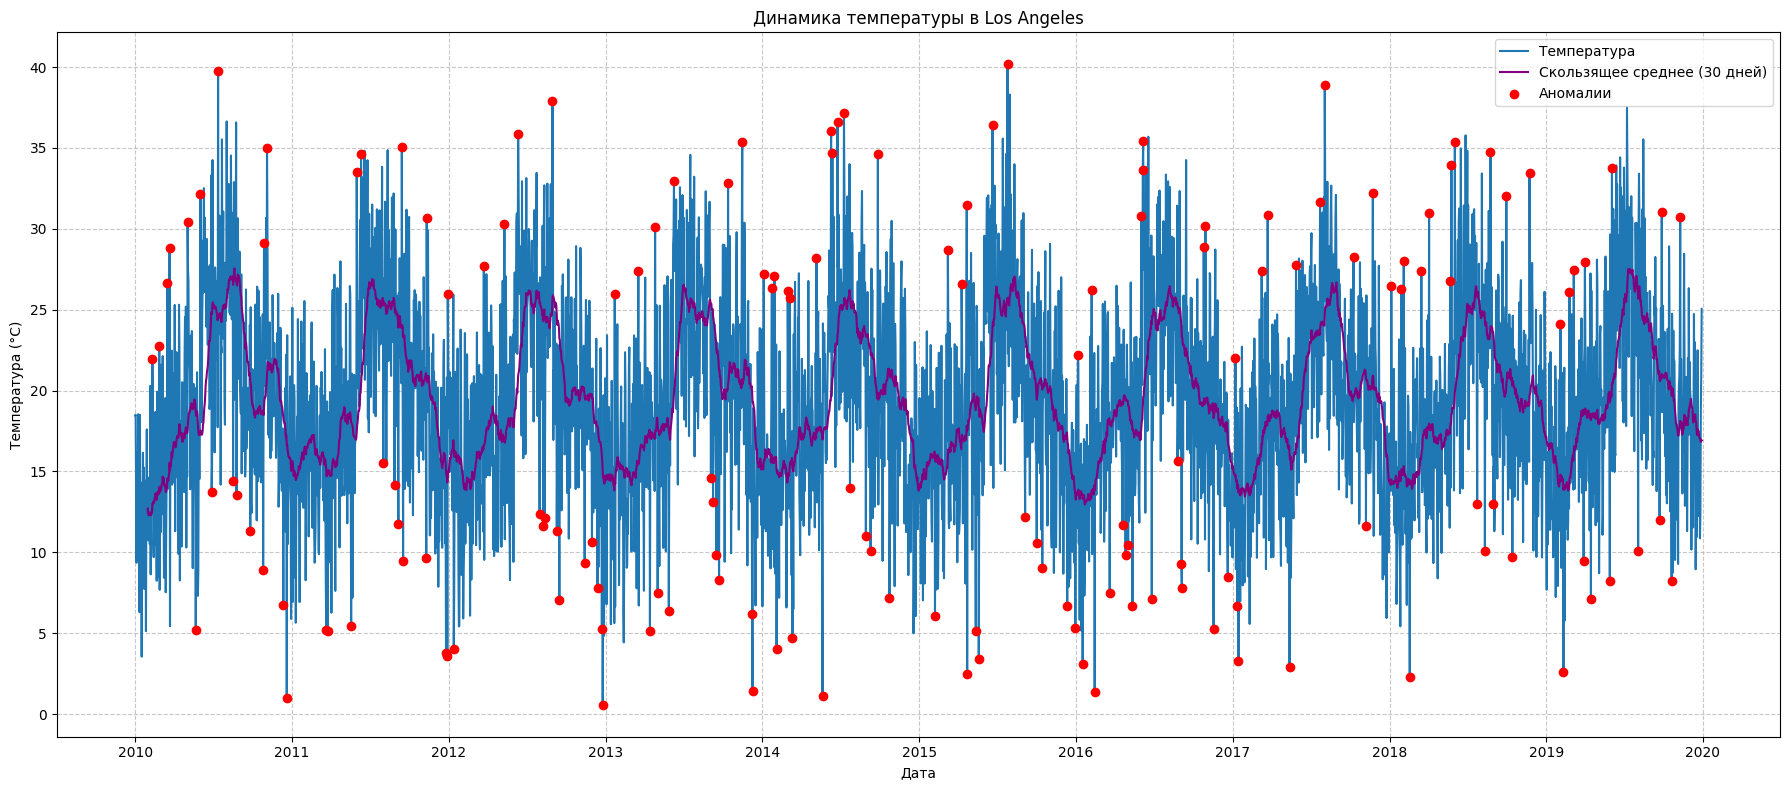

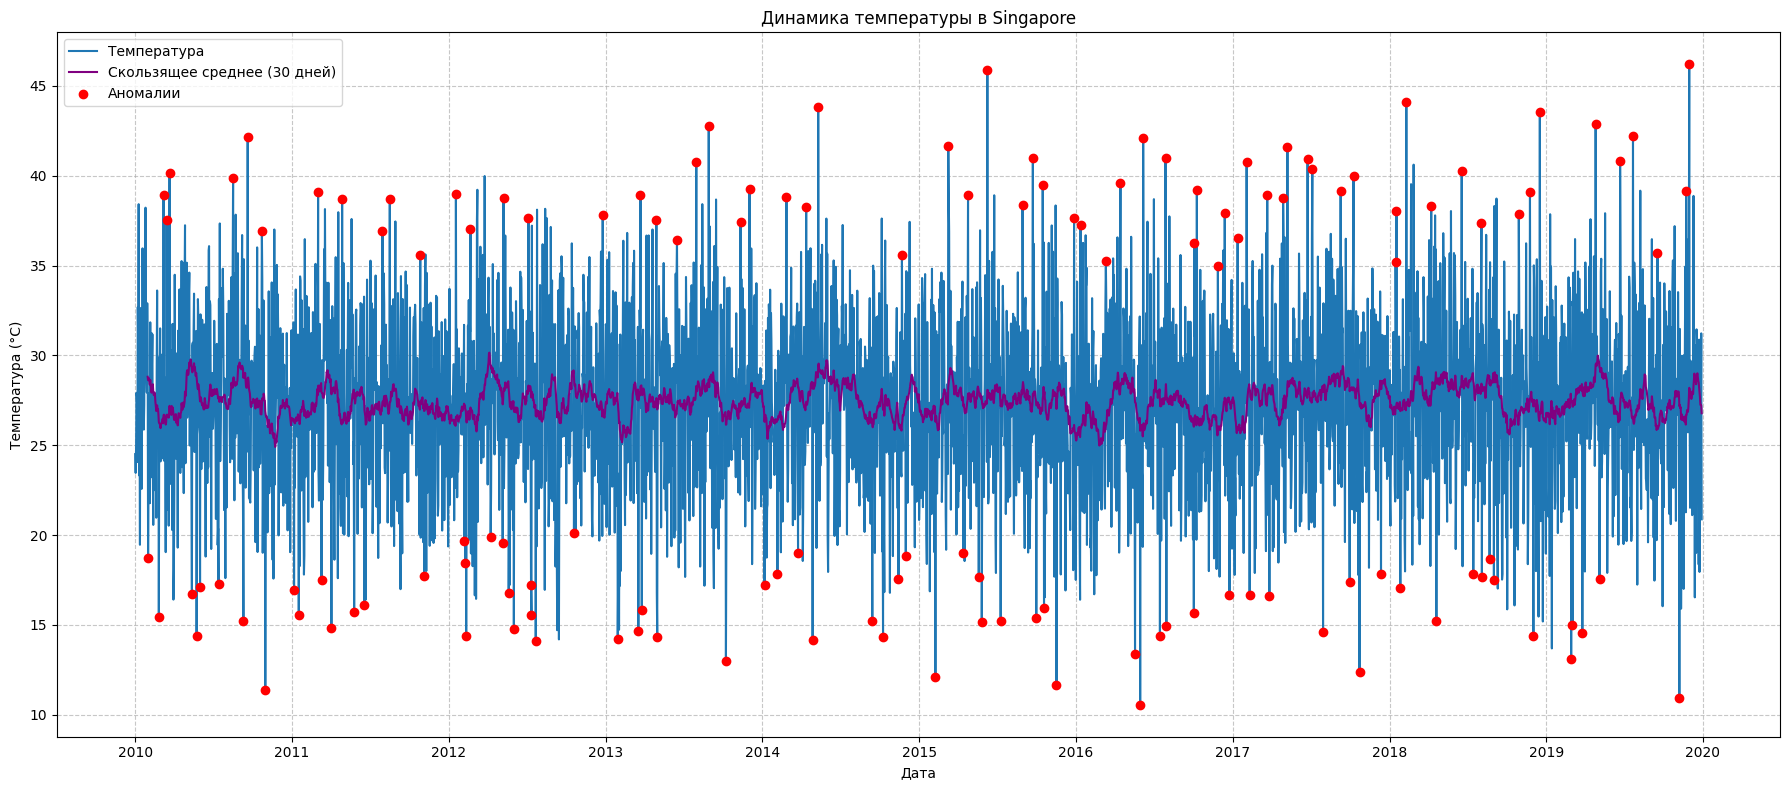

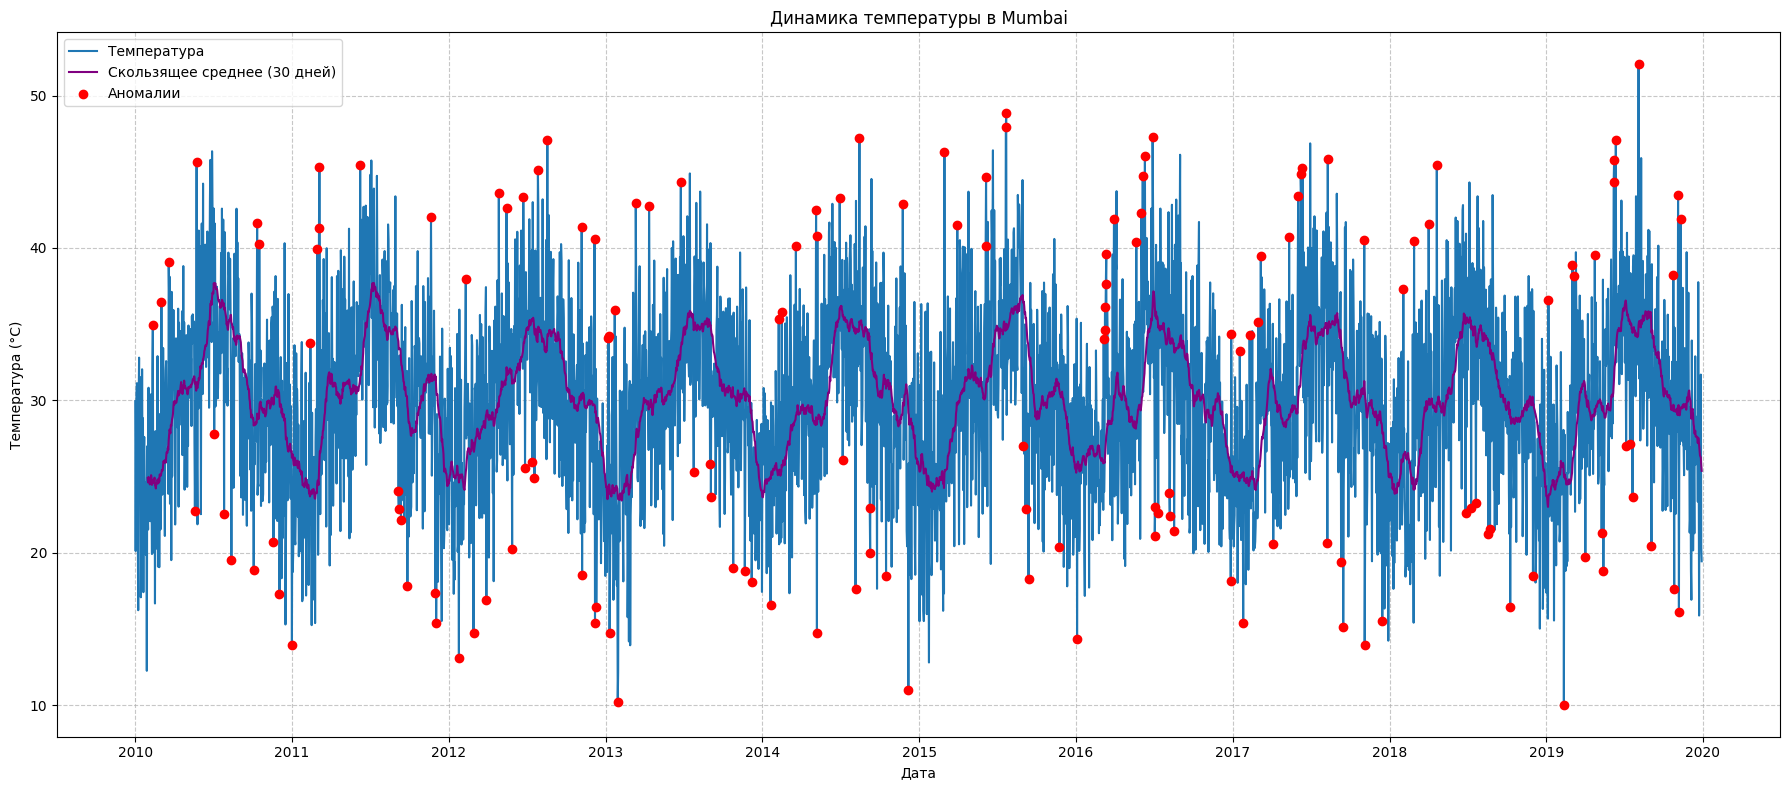

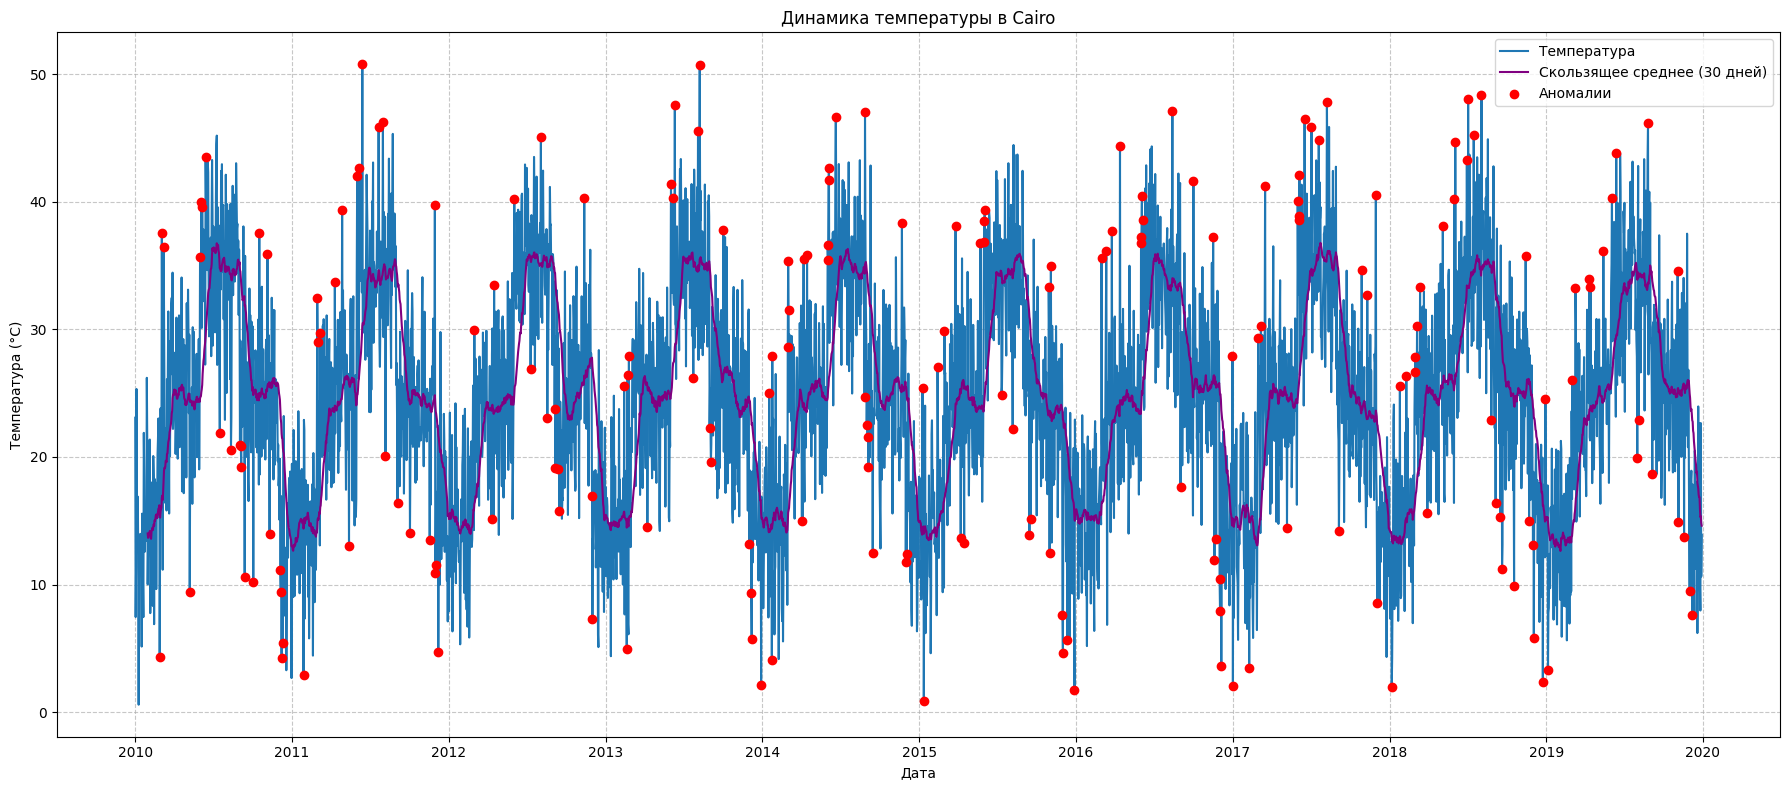

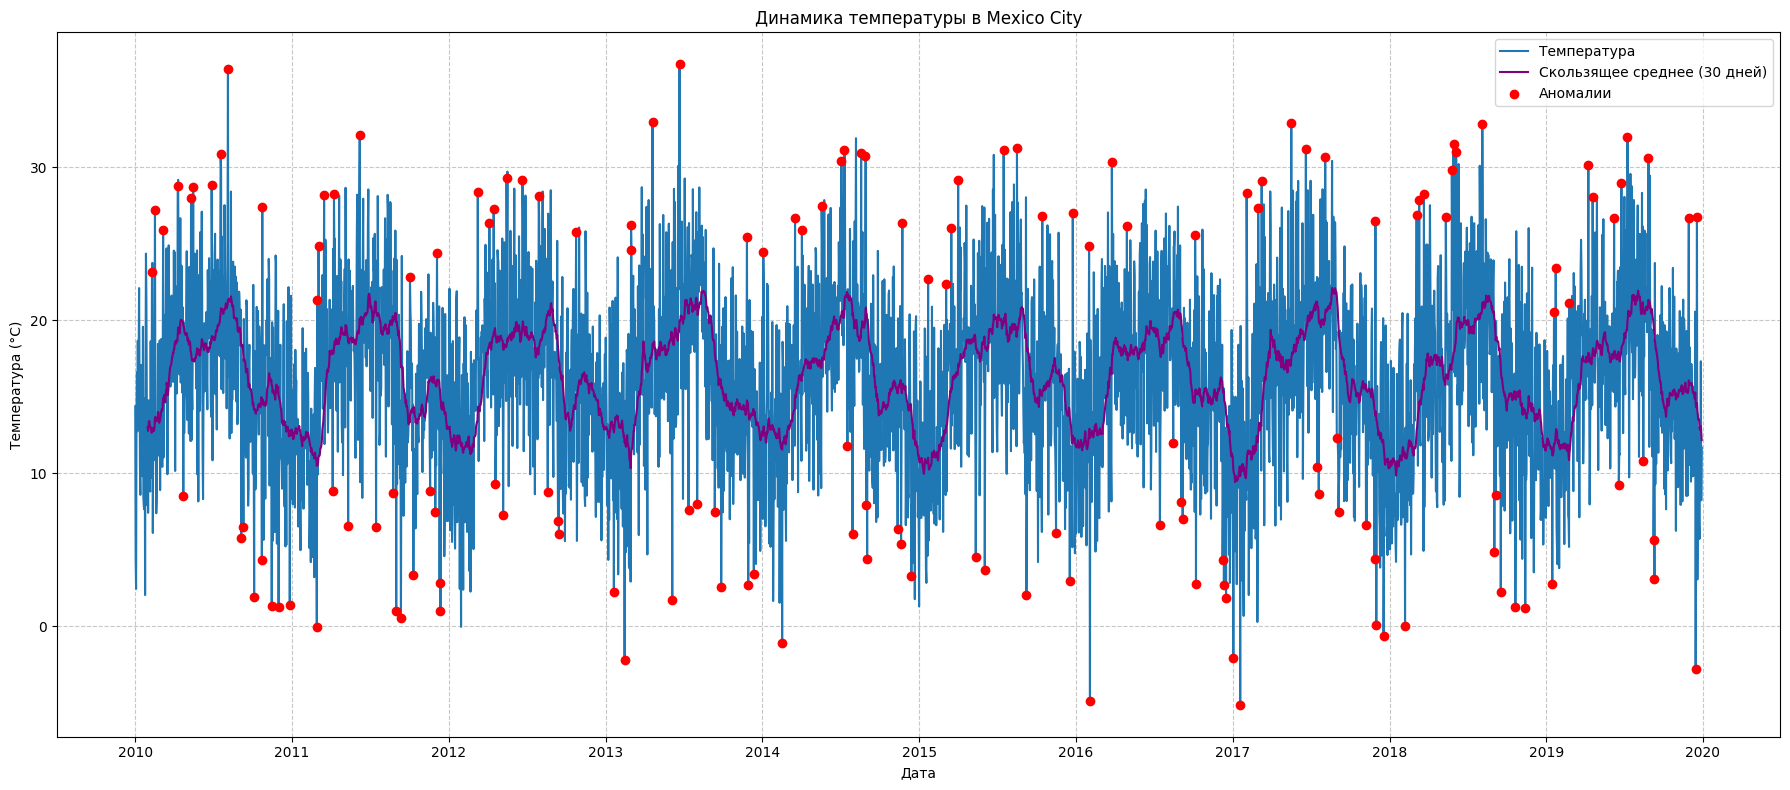

In [45]:
def visualize_temperature(data, city_name):
    # Визуализация временного ряда температуры
    plt.figure(figsize=(18, 8))
    plt.plot(data['timestamp'], data['temperature'], label='Температура')
    plt.plot(data['timestamp'], data['mean_temp'], label='Скользящее среднее (30 дней)', color='purple')
    anomalies = data[data['is_anomaly']]
    plt.scatter(anomalies['timestamp'], anomalies['temperature'], color='red', label='Аномалии', zorder=5)
    plt.title(f'Динамика температуры в {city_name}')
    plt.xlabel('Дата')
    plt.ylabel('Температура (°C)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

cities = default_processed_data['city'].unique()
for city in cities:
    city_data = default_processed_data[default_processed_data['city'] == city]
    visualize_temperature(city_data, city)

## Мониторинг текущей температуры:

Проверка скорости работы синхронных и асинхронных запросов

In [35]:
BASE_URL = "https://api.openweathermap.org/"

In [37]:
async def fetch_json(url):
    # Асинхронный запрос к API
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.json()

In [38]:
async def get_city_weather(city):
    # Получение информации о городе и температуре
    location_url = f"{BASE_URL}geo/1.0/direct?q={city}&appid={API_KEY}"
    location_data = await fetch_json(location_url)
    lat, lon = location_data[0]['lat'], location_data[0]['lon']
    weather_url = f"{BASE_URL}data/2.5/weather?lat={lat}&lon={lon}&units=metric&appid={API_KEY}"
    weather_data = await fetch_json(weather_url)

    return f"Температура в городе {location_data[0]['local_names']['ru']}: {weather_data['main']['temp']}"

In [42]:
print("Введите ключ OpenWeatherMap API:\n")
API_KEY = getpass()

Введите ключ OpenWeatherMap API:

··········


#### Проверка асинхронных запросов

In [43]:
start_time = time.time()
result = await asyncio.gather(get_city_weather("Moscow"), get_city_weather("Tokyo"))
print(f"Выполнено за {time.time()-start_time}")
print(result)

Выполнено за 0.16679716110229492
['Температура в городе Москва: -2.91', 'Температура в городе Токио: 3.79']


#### Проверка синхронных запросов

In [44]:
start_time = time.time()
result = [await get_city_weather(city) for city in ["Moscow", "Tokyo"]]
print(f"Выполнено за {time.time()-start_time}")
print(result)

Выполнено за 0.2116391658782959
['Температура в городе Москва: -2.91', 'Температура в городе Токио: 3.79']


Асинхронные запросы работают быстрее, потому что они позволяют приложению выполнять несколько операций одновременно. Вместо того чтобы дожидаться завершения одного запроса перед началом следующего, приложение может сразу отправить несколько запросов и обрабатывать их по мере получения ответов. Это существенно экономит время, особенно при работе с большим количеством запросов.